In [1]:
import networkx as nx
import numpy as np
import pandas as pd

# for the explode statement; convert string to list
from ast import literal_eval

# for visualization
from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 

In [2]:
def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5): 

    adjacency = nx.to_scipy_sparse_matrix(G, nodelist=None, dtype=None, weight='weight', format='csr') 

    names = np.array(list(G.nodes())) 

    graph = Bunch() 
    graph.adjacency = adjacency 
    graph.names = np.array(names) 

    pagerank = PageRank() 

    scores = pagerank.fit_transform(adjacency) 

    if show_names: 
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width) 

    else: 

        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width) 

    return SVG(image) 

# Create Graph using Bipartite Projection on Arxiv Dataset

In [3]:
data = r'C:\Users\groov\PythonCode\100daysofnetworks\data\arxiv_artificial_life.csv'

df = pd.read_csv(data)
df['authors'] = df['authors'].apply(literal_eval)

df = df[['authors', 'title']]
df = df.explode('authors')
df.reset_index(drop=True, inplace=True)

# fix the & so that scikit-network stops crashing
df['authors'] = df['authors'].str.replace('&', 'and')
df['title'] = df['title'].str.replace('&', 'and')

df.head()

,authors,title
0,Kiarash Sedghighadikolaei,A Comprehensive Survey of Threshold Digital Si...
1,Attila Altay Yavuz,A Comprehensive Survey of Threshold Digital Si...
2,Alenka {Č}opi{č},Phosphatidylserine transport in cell life and ...
3,Thibaud Dieudonné,Phosphatidylserine transport in cell life and ...
4,Guillaume Lenoir,Phosphatidylserine transport in cell life and ...


In [4]:
len(set(df['title']))

19989

In [5]:
from networkx.algorithms import bipartite

B = nx.from_pandas_edgelist(df, source='authors', target='title')
G = bipartite.projected_graph(B, df['authors'])

G = nx.k_core(G, 2) # no isolates or two-node groups

In [6]:
print(nx.info(G))

Graph with 48753 nodes and 273061 edges


# Community Detection + Community Analysis

There's two parts to what I am attempting today.
- I need to use community detection to identify communities in the network.
- I can then use network science and data science to identify interesting communities

By interesting, I mean not stars. I am looking for complex ecosystems. So, I will identify communities, then attempt to detect more complex ecosystems by using triangles and density.

In this notebook, I am experimenting with a python library for interactive visualization. 

## Community Detection

In [7]:
import community as community_louvain

partition = community_louvain.best_partition(G, resolution=0.01, random_state=1337) # 10 was good for this network

In [8]:
community_df = pd.DataFrame().from_dict(partition, orient='index')
community_df.reset_index(inplace=True)
community_df.columns = ['node', 'community']

community_df['community'].value_counts()[0:20]

93      90
637     73
227     68
1488    68
1041    67
4130    67
535     66
842     65
1285    63
20      63
89      62
65      62
1518    61
2552    60
1546    60
230     60
1881    60
5136    59
610     58
980     58
Name: community, dtype: int64

In [9]:
community_node_counts = community_df['community'].value_counts()

community_size_df = pd.DataFrame(community_node_counts).reset_index()
community_size_df.columns = ['community', 'node_count']

# just to speed up this experiment
community_size_df = community_size_df[community_size_df['node_count'] > 10]

community_size_df.head()

,community,node_count
0,93,90
1,637,73
2,227,68
3,1488,68
4,1041,67


In [10]:
community_size_df.shape

(956, 2)

## Capture Community Context

In [11]:
community_df.head()

,node,community
0,Alenka {Č}opi{č},0
1,Thibaud Dieudonné,0
2,Guillaume Lenoir,0
3,Michele Ambrosino,1
4,Manar Mahmalji,1


In [12]:
community_size_df.head(1)

,community,node_count
0,93,90


In [13]:
def get_community_nodes(community_df, community):

    return sorted(community_df[community_df['community']==community]['node'].values)

In [14]:
def get_community_context(community_size_df, community_df, G):

    G = G.copy()

    communities = {}

    for row in community_size_df.iterrows():

        data = row[1]
        community = data['community']
        node_count = data['node_count']
        
        nodes = get_community_nodes(community_df, community)
        G_sub = G.subgraph(nodes)

        # starting with density today; will add on more context later
        density = nx.density(G_sub)
        
        communities[community] = {}

        communities[community]['G'] = G_sub
        communities[community]['density'] = density
        communities[community]['node_count'] = len(G_sub.nodes)
        
    return communities

In [15]:
community_context_dict = get_community_context(community_size_df, community_df, G)

In [16]:
community_context_df = pd.DataFrame(community_context_dict).T.reset_index()
community_context_df.columns = ['community', 'G', 'density', 'node_count']

community_context_df.head()

,community,G,density,node_count
0,93,"(Antonis Bikakis, Veronica Dahl, Julian Padget...",0.073908,90
1,637,"(Alessandro Sperduti, Allar Soo, Bernat Coma-P...",0.085997,73
2,227,"(Chun Chen, Hong Zhang, Javier Llorca, Yonglia...",0.083406,68
3,1488,"(James D. McCalley, Xiaohong Gu, Wei Li, Wayne...",0.084284,68
4,1041,"(Karen I. Perez, David Lipman, J. Emilio Enriq...",0.383085,67


<AxesSubplot:ylabel='Frequency'>

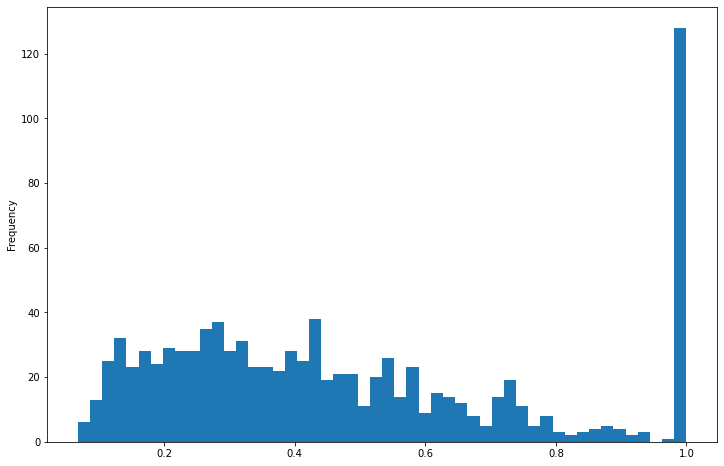

In [17]:
community_context_df['density'].plot.hist(bins=50, figsize=(12,8))

#### Investigate Communities

In [18]:
def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5): 

    adjacency = nx.to_scipy_sparse_matrix(G, nodelist=None, dtype=None, weight='weight', format='csr') 

    names = np.array(list(G.nodes())) 

    graph = Bunch() 
    graph.adjacency = adjacency 
    graph.names = np.array(names) 

    pagerank = PageRank() 

    scores = pagerank.fit_transform(adjacency) 

    if show_names: 
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width) 

    else: 

        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width) 

    return SVG(image) 

In [19]:
def show_author_papers(df, G):
    
    G = G.copy()
    
    check_nodes = G.nodes

    return sorted(df[df['authors'].isin(check_nodes)]['title'].unique())

In [20]:
def fetch_communities(community_context_df, min_density, max_density, max_nodes=None, n_communities=10):
    
    if max_nodes==None:
        community_context_df['node_count'].sum()
    
    community_context_df = community_context_df.copy()

    mask = (community_context_df['density']>min_density) \
        & (community_context_df['density']<max_density)  \
        & (community_context_df['node_count']<max_nodes)
    
    community_context_df = community_context_df[mask].copy()
    community_context_df = community_context_df.sample(n_communities) # grabbing ten to see the ranges

    community_context_df.sort_values('density', inplace=True)
    communities = community_context_df['community'].values[0:n_communities]
    
    return communities

In [21]:
def draw_community(G_check):

    print('Density: {}'.format(nx.density(G_check)))
    print('Node Count: {}'.format(len(G_check.nodes)))
    return draw_graph(G_check, show_names=True, node_size=3, edge_width=0.2)

In [22]:
min_density = 0.1
max_density = 0.3
max_nodes = 100

# .1 to .3 has more papers and more variation
# .3 to .6 is very cool
# .6 to .8 is cool to describe smaller more densely connected groups

# i did several iterations to find titles; sparse communities seem to have more and more interesting papers (opinion)

communities = fetch_communities(community_context_df, min_density=min_density, max_density=max_density, max_nodes=max_nodes, n_communities=20)
communities

array([ 215,  944,  811,  974,   25, 4321,  256, 1874,  927, 1644, 1165,
        836,  878,   89,  511, 2427, 1345, 1094, 2464, 1274], dtype=int64)

Density: 0.11215686274509803
Node Count: 51


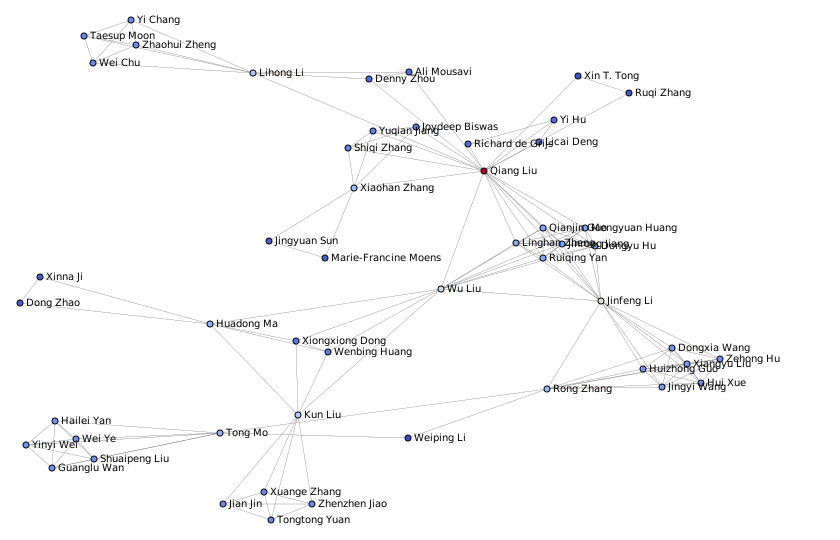

In [23]:
G_check = community_context_dict[communities[0]]['G']
draw_community(G_check)

In [24]:
show_author_papers(df, G_check)

#Efficient Top-k Ego-Betweenness Search
#Fast Algorithms for Intimate-Core Group Search in Weighted Graphs
#Fine-Grained Emotion Classification of Chinese Microblogs Based on Graph Convolution Networks
#Mining Bursting Communities in Temporal Graphs

['Belief Propagation for Structured Decision Making',
 'Black-box Off-policy Estimation for Infinite-Horizon Reinforcement Learning',
 'CAINNFlow: Convolutional block Attention modules and Invertible Neural Networks Flow for anomaly detection and localization tasks',
 'Data characterization using artificial-star tests: performance evaluation',
 'Exploiting Pseudo Future Contexts for Emotion Recognition in Conversations',
 'FairRec: Fairness Testing for Deep Recommender Systems',
 'Generalized Lottery Trees: Budget-Consistent Incentive Tree Mechanisms for Crowdsourcing',
 'Generalized Zero-Shot Learning for Action Recognition with Web-Scale Video Data',
 'ICE: Information Credibility Evaluation on Social Media via Representation Learning',
 'LLM+P: Empowering Large Language Models with Optimal Planning Proficiency',
 'Mining Significant Microblogs for Misinformation Identification: An Attention-based Approach',
 'Refining Recency Search Results with User Click Feedback',
 'Review of Dee

# Interactive Exploration

I'll use G_check graph with libraries for interactive exploration.

In [25]:
#!pip install pyvis --upgrade --user
#!pip install pyvis==0.3.1 --user

In [26]:
from pyvis.network import Network

In [69]:
pyvis_file = r'C:\Users\groov\PythonCode\100daysofnetworks\pyvis/arxiv_community.html'

nt = Network()
nt.from_nx(G_check)
nt.show(pyvis_file, notebook=False)

C:\Users\groov\PythonCode\100daysofnetworks\pyvis/arxiv_community.html


In [59]:
#from IPython.display import display, HTML

In [60]:
# import IPython
# IPython.display.HTML(filename=pyvis_file)